# micrograd

Basic autograd engine implementation from the karpathy's series

In [546]:
import math
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [547]:
def f(x):
    return x**2 + 2*x + 1

In [548]:
f(8.0)

81.0

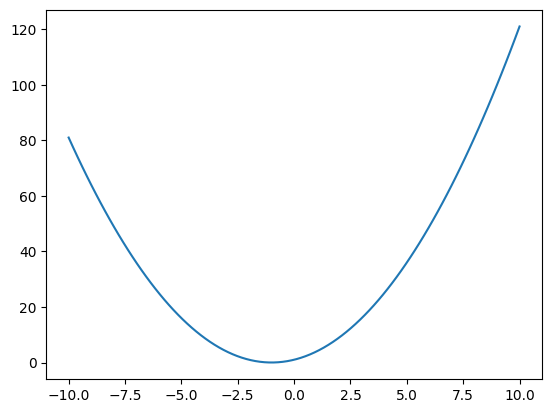

In [549]:
X = jnp.linspace(-10, 10, 100)
Y = f(X)

plt.plot(X, Y)

In [550]:
h = 0.0000000001
x = 3.0
(f(x + h) - f(x)) / h

8.000000661922968

In [551]:
a = 2.0
b = 1.0
c = 10.0

d = a * b + c

print(d)

12.0


In [552]:
h = 0.001

a = 2.0
b = -1.0
c = 10.0

d1 = a * b + c
d2 = (a + h) * b + c

print(f'd1: {d1}')
print(f'd2: {d2}')

slope = (d2 - d1) / h

print(f'slope: {slope}')

d1: 8.0
d2: 7.9990000000000006
slope: -0.9999999999994458


### Value

Basic scalar wrapper

In [553]:
class Value:

    def __init__(self, data, _children = (), _op = '', label = '', grad = 0.0):
        self.data =data
        self._pred = set(_children)
        self._op = _op
        self.label = label
        self.grad = grad
        self._backward = lambda: None

    def __repr__(self):
        return f'Value(data = {self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other, label = str(other))
        out = Value(self.data + other.data, (self, other), '+', f'{self.label} + {other.label}')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, label = str(other))
        out = Value(self.data * other.data, (self, other), '*', f'{self.label} * {other.label}')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int/float powers for now'
        out = Value(self.data**other, (self,), f'**{other}', f'({self.label})**{other}')

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other**-1

    def exp(self):
        f = jnp.exp(self.data)
        out = Value(f, (self,), 'exp', f'e^({self.label})')

        def _backward():
            self.grad += f * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        f = jnp.tanh(self.data)
        out = Value(f, (self,), 'tanh', f'tanh({self.label})')

        def _backward():
            self.grad += (1 - f**2) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        def toposort(root):
            visited = set()
            order = []    
            def dfs(u):
                if u in visited:
                    return
                visited.add(u)
                for v in u._pred:
                    dfs(v)
                order.append(u)
            dfs(root)
            return order
    
        self.grad = 1.0
        for v in reversed(toposort(self)):
            v._backward()


In [554]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(u):
        if u not in nodes:
            nodes.add(u)
            for v in u._pred:
                edges.add((v, u))
                build(v)
    
    build(root)
    return nodes, edges

def draw(root, no_labels = False):
    
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        label_str = f'{{ {n.label} | {n.data:.2f} | {n.grad:.2f} }}' if not no_labels else f'{{ {n.data:.2f} | {n.grad:.2f} }}'
        dot.node(name = uid, label = label_str, shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n, m in edges:
        dot.edge(str(id(n)), str(id(m)) + m._op)

    return dot


In [555]:
a = Value(2.0, label = 'a')
b = Value(-1.0, label = 'b')
c = Value(10.0, label = 'c')

d = a * b + c
d.label = 'd'
print(d)  

e = a * b
e.label = 'e'
print(e)  

f = e + c
f.label = 'f'
print(f)  

g = Value(-3.0, label = 'g')

i = f * g
i.label = 'i'
print(i)  
  

Value(data = 8.0)
Value(data = -2.0)
Value(data = 8.0)
Value(data = -24.0)


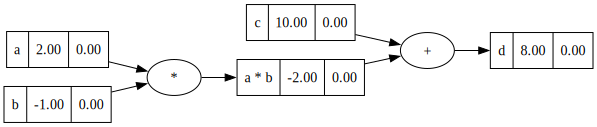

In [556]:
draw(d)

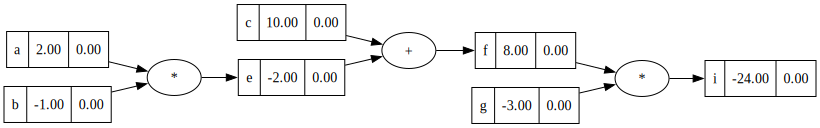

In [557]:
draw(i)

In [558]:
# for funsies: evaluate with graph

def operate(u, v, op):
    if op == '+':
        return u + v
    if op == '*':
        return u * v
    else:
        raise ValueError(f'Unknown operation: {op}')

def evaluate(u):

    print(f'evaluating {u.label}')

    if u._op == '':
        return u.data
    
    pred_values = [evaluate(v) for v in u._pred]
    val = operate(*pred_values, u._op)
    return val

print(evaluate(d))
print(evaluate(i) == i.data)

evaluating d
evaluating c
evaluating a * b
evaluating b
evaluating a
8.0
evaluating i
evaluating g
evaluating f
evaluating e
evaluating b
evaluating a
evaluating c
True


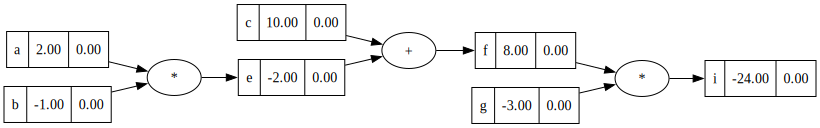

In [559]:
draw(i)

### Getting the gradient by hand

To compute the derivative $\frac{di}{da}$ using the chain rule:

$\frac{di}{da} = \frac{di}{df} \cdot \frac{df}{de} \cdot \frac{de}{da}$

Given: $e = a \cdot b$, $\frac{de}{da} = b$

Given: $f = c + e$, $\frac{df}{de} = 1$

Given: $i = g \cdot f$, $\frac{di}{df} = g$

Thus:
$\frac{di}{da} = g \cdot 1 \cdot b = g \cdot b$

For $g = -3.0$ and $b = -1.0$, $\frac{di}{da} = (-3.0) \cdot (-1.0) = 3$

In [560]:
def numeric_gradient():
    
    h = 0.0000000001

    a = Value(2.0, label = 'a')
    b = Value(-1.0, label = 'b')
    c = Value(10.0, label = 'c') 
    
    e = a * b
    f = e + c
    g = Value(-3.0, label = 'g')
    i = f * g
    L1 = i.data

    a = Value(2.0 + h, label = 'a')
    b = Value(-1.0, label = 'b')
    c = Value(10.0, label = 'c') 
    
    e = a * b
    f = e + c
    g = Value(-3.0, label = 'g')
    i = f * g
    L2 = i.data

    return (L2 - L1) / h

print(numeric_gradient())

2.999982484652719


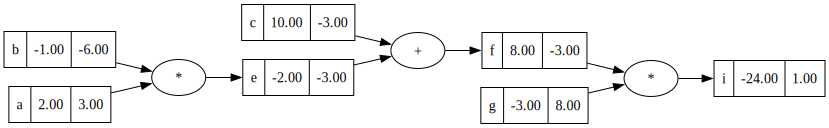

In [561]:
a = Value(2.0, label = 'a', grad=3.0)
b = Value(-1.0, label = 'b', grad=-6.0)
c = Value(10.0, label = 'c', grad=-3.0) 

e = a * b
e.label = 'e'

f = e + c
f.label = 'f'

g = Value(-3.0, label = 'g', grad=8.0)

i = f * g
i.label = 'i'
i.grad = 1.0

f.grad = g.data * i.grad
e.grad = f.grad 

draw(i)

In [562]:
step = 0.001

a.data += a.grad * step
b.data += b.grad * step
c.data += c.grad * step
g.data += g.grad * step

e = a * b
f = e + c
i = f * g

print(i.data)

-23.882090144


### Getting gradient with backward()

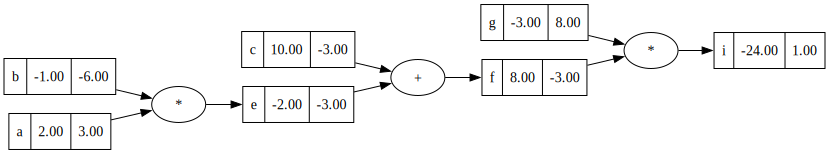

In [563]:
a = Value(2.0, label = 'a')
b = Value(-1.0, label = 'b')
c = Value(10.0, label = 'c') 

e = a * b
e.label = 'e'
f = e + c
f.label = 'f'
g = Value(-3.0, label = 'g')
i = f * g

i.label = 'i'
i.grad = 1.0

i._backward()
g._backward()
f._backward()
e._backward()
a._backward()
b._backward()
c._backward()

draw(i)

### Neuron example

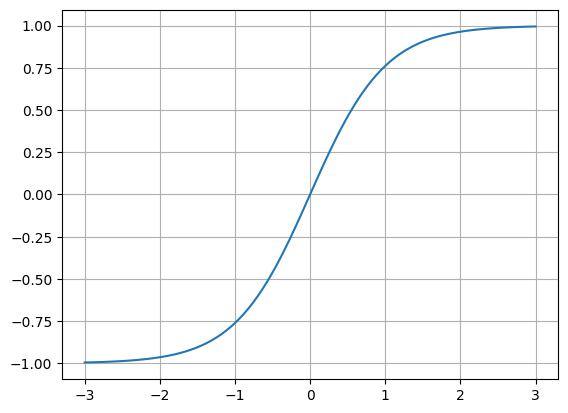

In [564]:
# activation function

X = jnp.linspace(-3, 3, 100)
Y = jnp.tanh(X)

plt.grid()
plt.plot(X, Y)

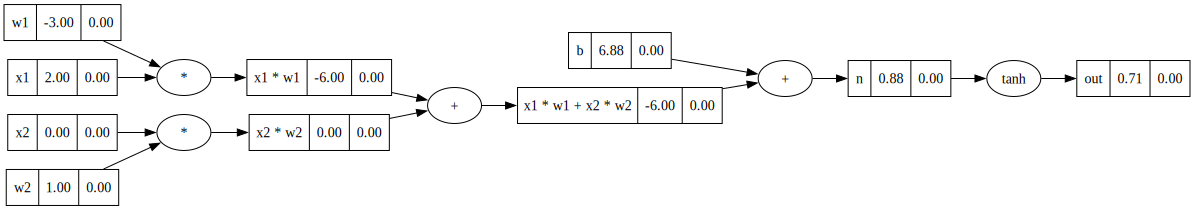

In [565]:
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias
b = Value(6.88, label = 'b')

# weighted sum + bias (linear combination)
x1w1 = x1 * w1
x2w2 = x2 * w2

x1w1x2w2 = x1w1 + x2w2

n = x1w1x2w2 + b
n.label = 'n'

out = n.tanh()
out.label = 'out'

draw(out)


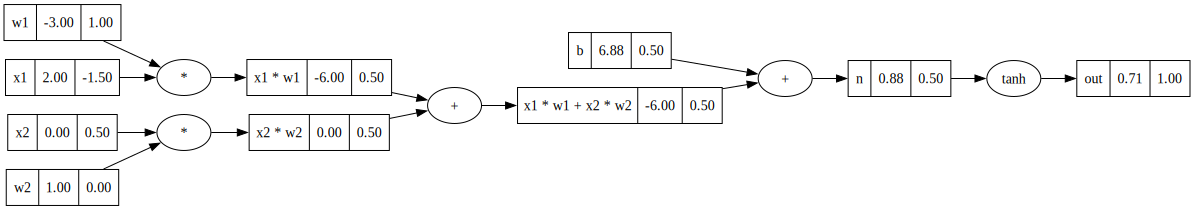

In [566]:
out.grad = 1.0

out._backward()

n._backward()

b._backward()

x1w1x2w2._backward()

x1w1._backward()

x2w2._backward()

x1._backward()
w1._backward()

x2._backward()
w2._backward()

draw(out)

## Backpropagation

Using topological sort

In [567]:
# simple dfs-based toposort

def toposort(root):
    visited = set()
    order = []
    
    def dfs(u):

        if u in visited:
            return
        visited.add(u)

        for v in u._pred:
            dfs(v)
            
        order.append(u)
    
    dfs(root)
    return order

In [568]:
order = toposort(out)

for u in reversed(order):
    print(u)

Value(data = 0.7064193203972353)
Value(data = 0.8799999999999999)
Value(data = -6.0)
Value(data = -6.0)
Value(data = 2.0)
Value(data = -3.0)
Value(data = 0.0)
Value(data = 1.0)
Value(data = 0.0)
Value(data = 6.88)


In [569]:
# backward pass
def backward(root):
    order = toposort(root)
    root.grad = 1.0
    for u in reversed(order):
        u._backward()

On small network with atomic tanh


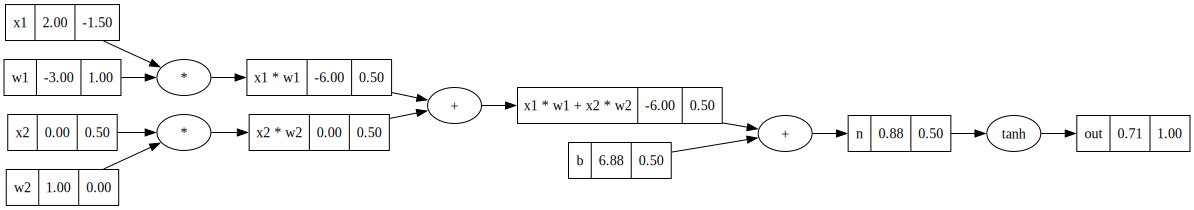

In [570]:
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias
b = Value(6.88, label = 'b')

# weighted sum + bias (linear combination)
x1w1 = x1 * w1
x2w2 = x2 * w2

x1w1x2w2 = x1w1 + x2w2

n = x1w1x2w2 + b
n.label = 'n'

out = n.tanh()
out.label = 'out'

# backward(out)
out.backward()

draw(out)


On small network with composite tanh


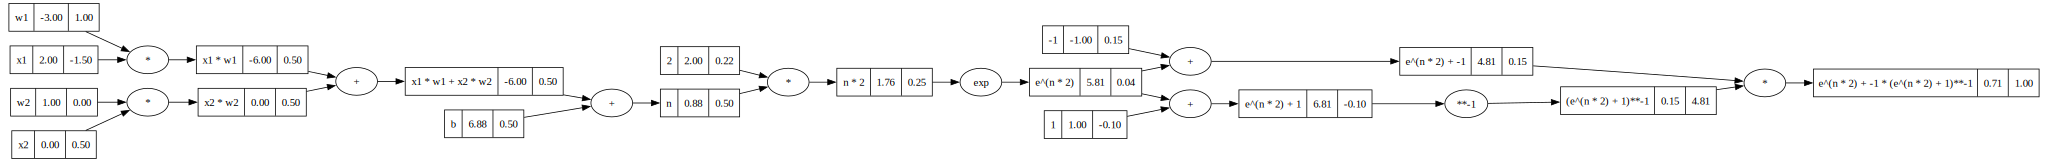

In [571]:

# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias
b = Value(6.88, label = 'b')

# weighted sum + bias (linear combination)
x1w1 = x1 * w1
x2w2 = x2 * w2

x1w1x2w2 = x1w1 + x2w2

n = x1w1x2w2 + b
n.label = 'n'

e = (2 * n).exp() 
out = (e - 1) / (e + 1)

# backward(out)
out.backward()

draw(out)


### in JAX

In [572]:
import jax

# Enable float64 precision
jax.config.update("jax_enable_x64", True)

# Define the forward pass function
def forward(w1, w2, b, x1, x2):
    n = x1 * w1 + x2 * w2 + b
    return jnp.tanh(n)

# Create gradient functions for each parameter and input
grad_w1 = jax.grad(forward, argnums=0)
grad_w2 = jax.grad(forward, argnums=1)
grad_b = jax.grad(forward, argnums=2)
grad_x1 = jax.grad(forward, argnums=3)
grad_x2 = jax.grad(forward, argnums=4)

w1 = -3.0
w2 = 1.0
b = 6.8813735870195432
x1 = 2.0
x2 = 0.0

# Compute the output
output = forward(w1, w2, b, x1, x2)

# Compute gradients
dw1 = grad_w1(w1, w2, b, x1, x2)
dw2 = grad_w2(w1, w2, b, x1, x2)
db = grad_b(w1, w2, b, x1, x2)
dx1 = grad_x1(w1, w2, b, x1, x2)
dx2 = grad_x2(w1, w2, b, x1, x2)

print(output.item())
print('---')
print('x2', dx2.item())
print('w2', dw2.item())
print('x1', dx1.item())
print('w1', dw1.item())

0.7071067811865477
---
x2 0.4999999999999998
w2 0.0
x1 -1.4999999999999993
w1 0.9999999999999996


# Neural Network Stuff

In [573]:
import random

In [574]:
from typing import Any


class Neuron:

    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        output = [neuron(x) for neuron in self.neurons]
        return output[0] if len(output) == 1 else output
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, n_in, n_hidden, n_out):
        sz = [n_in] + n_hidden + [n_out]
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(sz) - 1)]        

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [575]:
x = [2.0, 3.0, -1.0]
nn = MLP(3, [4, 4], 1)
y = nn(x)

print(y)

Value(data = 0.9467606167302862)


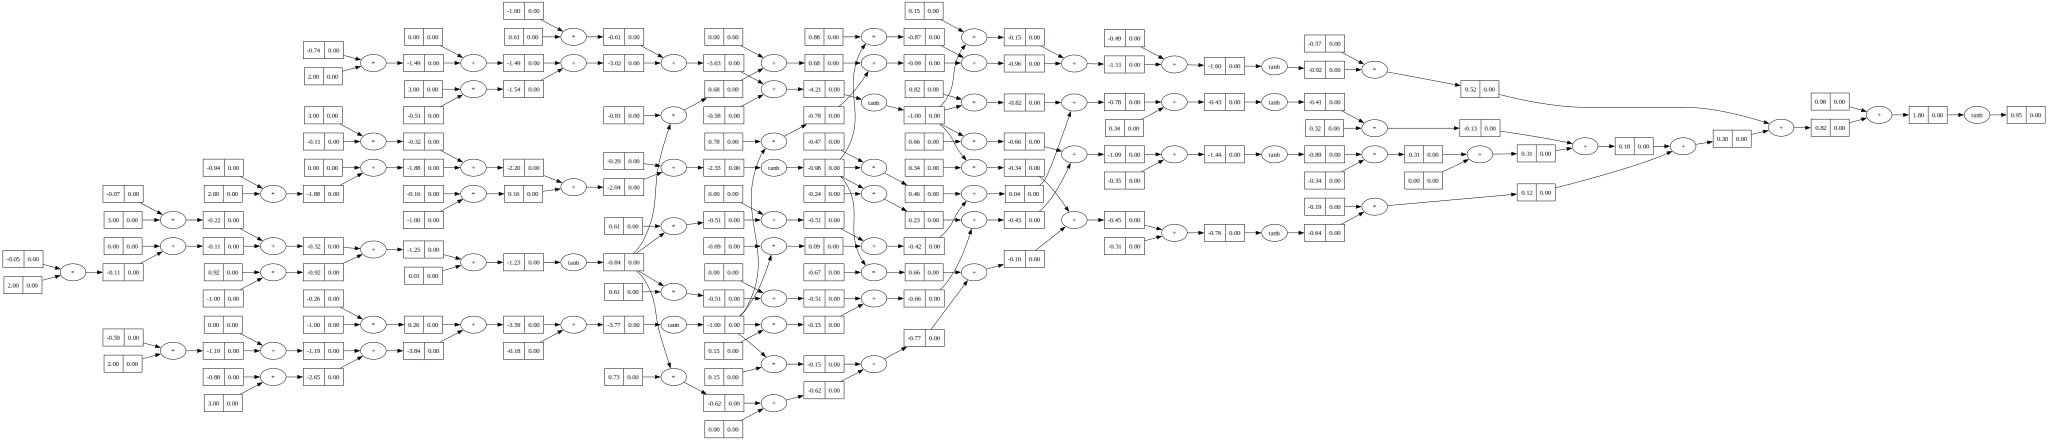

In [576]:
draw(y, no_labels=True)

In [577]:
x = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

y = [1.0, -1.0, -1.0, 1.0]

nn = MLP(3, [4, 4], 1)

In [578]:
ypred = [nn(xi) for xi in x]
print(ypred)

loss = sum([(yi - yt)**2 for yi, yt in zip(ypred, y)])
print(loss)

[Value(data = 0.8500646512048077), Value(data = 0.2178358181817192), Value(data = 0.6238073751805565), Value(data = 0.6631351144149625)]
Value(data = 4.255833031695663)


In [579]:
loss.backward()

In [580]:
print(len(nn.parameters()))

41


In [581]:
print(nn.layers[0].neurons[0].w[0].grad)

0.001700895680167504


In [582]:
print(nn.layers[0].neurons[0].w[0].data)

0.2719439176072256


## Training the network

In [583]:
for p in nn.parameters():
    p.data -= p.grad * 0.001

In [584]:
print(nn.layers[0].neurons[0].w[0].data)

0.2719422167115454


In [585]:
ypred = [nn(xi) for xi in x]
print(ypred)

loss = sum([(yi - yt)**2 for yi, yt in zip(ypred, y)])
print(loss)

[Value(data = 0.8470516499147188), Value(data = 0.20274592123449556), Value(data = 0.6140978863783064), Value(data = 0.6581565947643446)]
Value(data = 4.1921598493540495)


### Training loop

In [586]:
x = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

y = [1.0, -1.0, -1.0, 1.0]

nn = MLP(3, [4, 4], 1)

In [587]:
for k in range(200):

    # forward pass
    ypred = [nn(xi) for xi in x]
    loss = sum([(yi - yt)**2 for yi, yt in zip(ypred, y)])

    # backward pass
    for p in nn.parameters():
        p.grad = 0.0

    loss.backward()

    # update weights
    for p in nn.parameters():
        p.data -= p.grad * 0.01

    print(f'iteration {k}, loss {loss.data}')

iteration 0, loss 3.6704005249041876
iteration 1, loss 3.439996870078913
iteration 2, loss 3.2752579262819923
iteration 3, loss 3.1553138142381227
iteration 4, loss 3.064796573277113
iteration 5, loss 2.9931276899761894
iteration 6, loss 2.9334425308615
iteration 7, loss 2.8814283781470955
iteration 8, loss 2.8343988257268666
iteration 9, loss 2.790661692112723
iteration 10, loss 2.749120716822564
iteration 11, loss 2.7090350149644706
iteration 12, loss 2.6698768627417584
iteration 13, loss 2.631248332803845
iteration 14, loss 2.5928324641641574
iteration 15, loss 2.554364567424529
iteration 16, loss 2.51561531205131
iteration 17, loss 2.4763807989223694
iteration 18, loss 2.436476874943057
iteration 19, loss 2.3957361214876305
iteration 20, loss 2.354006617234433
iteration 21, loss 2.3111519539431242
iteration 22, loss 2.2670521931242904
iteration 23, loss 2.22160556110835
iteration 24, loss 2.174730728303902
iteration 25, loss 2.126369527438464
iteration 26, loss 2.0764899486403605
i

In [588]:
print(ypred)

[Value(data = 0.9114056540019003), Value(data = -0.9475844604994922), Value(data = -0.8409090518807724), Value(data = 0.8769322526904397)]


Test with XOR

In [589]:
x = [
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
]

y = [0.0, 1.0, 1.0, 0.0]

nn = MLP(2, [4, 4], 1)

In [590]:
for k in range(1000):

    # forward pass
    ypred = [nn(xi) for xi in x]
    loss = sum([(yi - yt)**2 for yi, yt in zip(ypred, y)])

    # backward pass
    for p in nn.parameters():
        p.grad = 0.0

    loss.backward()

    # update weights
    for p in nn.parameters():
        p.data -= p.grad * 0.01

    print(f'iteration {k}, loss {loss.data}')

iteration 0, loss 1.3769973660397592
iteration 1, loss 1.3413701086631236
iteration 2, loss 1.3050903137479566
iteration 3, loss 1.2687278887228037
iteration 4, loss 1.232920731430334
iteration 5, loss 1.1983276579456374
iteration 6, loss 1.1655716226004826
iteration 7, loss 1.1351833284713764
iteration 8, loss 1.1075564368327493
iteration 9, loss 1.0829229506462363
iteration 10, loss 1.061351875333544
iteration 11, loss 1.0427682627441635
iteration 12, loss 1.0269855686556062
iteration 13, loss 1.0137430209325857
iteration 14, loss 1.0027410170440132
iteration 15, loss 0.9936701907641048
iteration 16, loss 0.9862324535188651
iteration 17, loss 0.980154282042363
iteration 18, loss 0.9751936035447504
iteration 19, loss 0.971141982211511
iteration 20, loss 0.9678237106454154
iteration 21, loss 0.9650931008877185
iteration 22, loss 0.9628309144454996
iteration 23, loss 0.9609405542568239
iteration 24, loss 0.959344394974561
iteration 25, loss 0.9579804527048611
iteration 26, loss 0.956799

In [591]:
print(ypred)

[Value(data = 0.008050027739115855), Value(data = 0.9212120529540425), Value(data = 0.9452119546589839), Value(data = 0.010793830398440516)]
